# Predicting Diabetes in Patients

## Introduction ##

Diabetes is a chronic medical condition where patients are either unable to make enough insulin or their body doesn't respond to the insulin it produces. In either case, the blood sugar levels in patients become high as the body can’t store the sugar properly in the body. These high blood sugar levels can cause serious health problems over time.

Our question will be to see if we can predict diabetes in a patient, given a set of diagnostic measurements for each patient. 

The dataset we’ll be using can be found here: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

The dataset is a subset of data taken from the National Institute of Diabetes and Digestive and Kidney Diseases. It focuses specifically on female patients at least 21 years old of Pima Indian heritage.

## Preliminary Data Exploration ##

In [5]:
### Run this cell before continuing.
import altair as alt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [6]:
URL = "https://raw.githubusercontent.com/adipoluri/DSCI-100-Project/main/diabetes.csv"
diabetes_raw_df = pd.read_csv(URL)
diabetes_raw_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


We noticed that there were 0 values in the following columns: "Glucose", "BloodPressure", "SkinThickness", "Insulin" and "BMI.

On pg 263 of the paper that previously used this dataset(see the "Past Usage" section in the Kaggle link), we can see from Table 1 that there were "BLANK" values for each of these features. We believe the 0 values that we're seeing in the columns represent those "BLANK" values, so we have decided to remove examples that have 0 in any of those columns from the dataset we'll be using for the remainder of this project (see below).

In [8]:
diabetes_df = diabetes_raw_df[
(diabetes_raw_df["Glucose"] > 0) & (diabetes_raw_df["BloodPressure"] > 0) & (diabetes_raw_df["SkinThickness"] > 0) &
(diabetes_raw_df["Insulin"] > 0) & (diabetes_raw_df["BMI"] > 0)]

diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0


In [9]:
diabetes_df.describe(include = "all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
train_df, test_df = train_test_split(diabetes_df, test_size=0.25, random_state=123)

In [16]:
train_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
260,3,191,68,15,130,30.9,0.299,34,0
548,1,164,82,43,67,32.8,0.341,50,0
27,1,97,66,15,140,23.2,0.487,22,0
320,4,129,60,12,231,27.5,0.527,31,0
599,1,109,38,18,120,23.1,0.407,26,0
...,...,...,...,...,...,...,...,...,...
450,1,82,64,13,95,21.2,0.415,23,0
204,6,103,72,32,190,37.7,0.324,55,0
631,0,102,78,40,90,34.5,0.238,24,0
744,13,153,88,37,140,40.6,1.174,39,0


In [17]:
train_summary = train_df.describe()
train_summary

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,3.302721,123.908163,70.721088,29.187075,156.996599,33.324830,0.540650,30.955782,0.340136
std,3.245400,31.507002,12.458139,10.518099,123.516604,7.380823,0.358113,10.348604,0.474562
min,0.000000,56.000000,30.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.000000,22.000000,76.000000,28.400000,0.289000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,29.000000,126.000000,33.100000,0.465000,27.000000,0.000000
75%,5.000000,144.750000,78.000000,37.000000,190.750000,37.575000,0.690750,36.750000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 260 to 711
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               294 non-null    int64  
 1   Glucose                   294 non-null    int64  
 2   BloodPressure             294 non-null    int64  
 3   SkinThickness             294 non-null    int64  
 4   Insulin                   294 non-null    int64  
 5   BMI                       294 non-null    float64
 6   DiabetesPedigreeFunction  294 non-null    float64
 7   Age                       294 non-null    int64  
 8   Outcome                   294 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 23.0 KB


In [22]:
numeric_cols_initial = list(train_summary.select_dtypes([np.number]).columns) 
numeric_cols_initial

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [56]:
numeric_cols = numeric_cols_initial[:8]
numeric_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

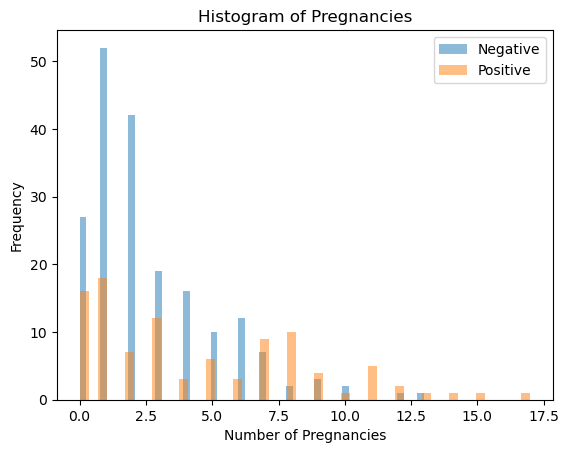

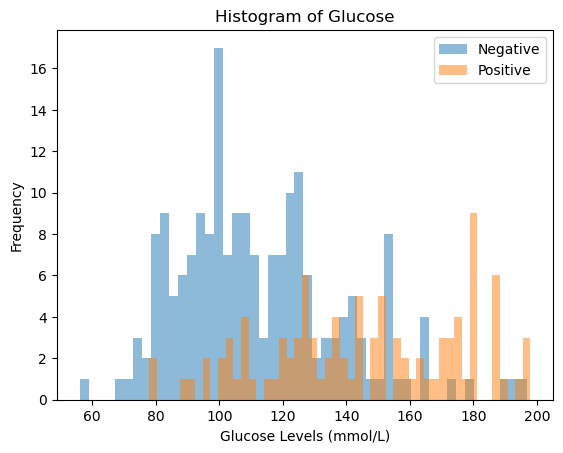

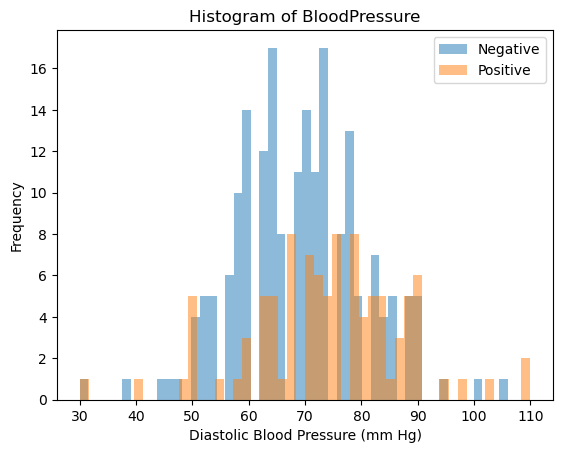

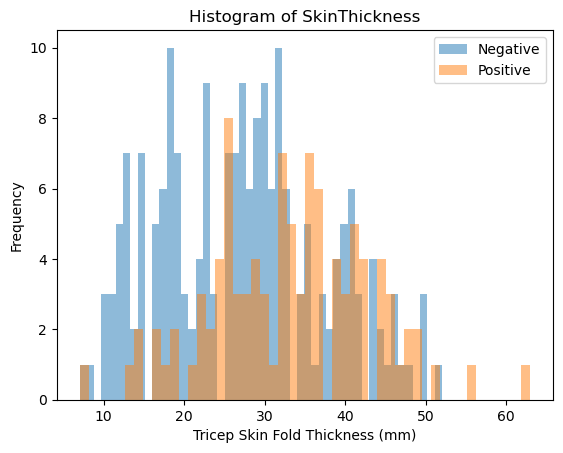

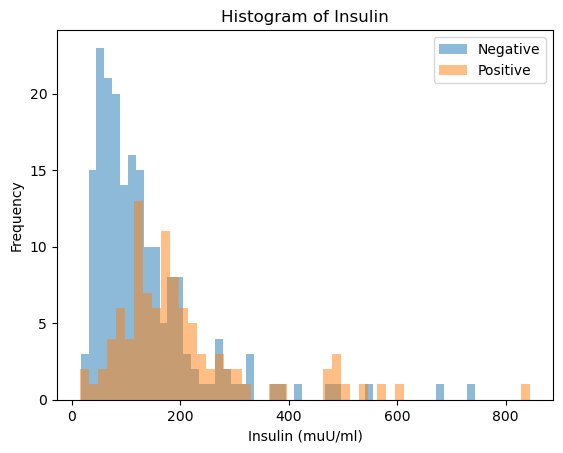

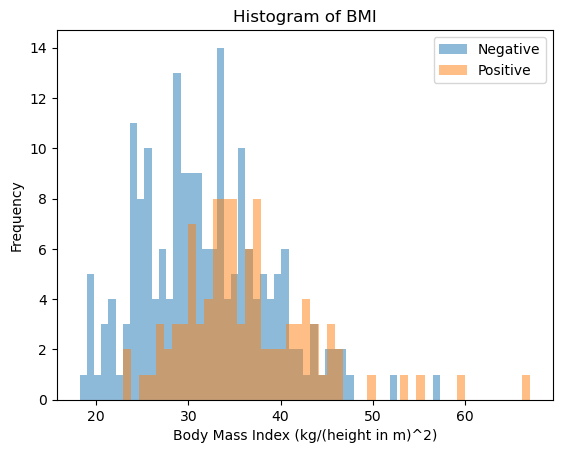

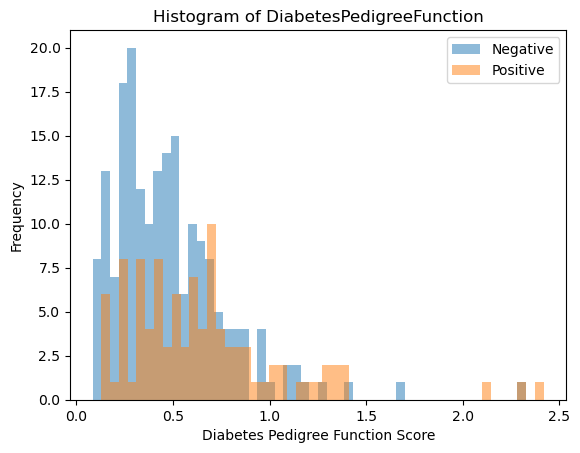

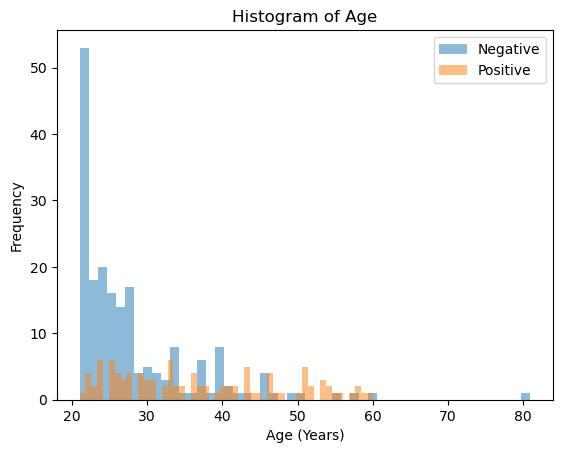

In [57]:
## Pregnancies ##
units = {
    "Pregnancies":"Number of Pregnancies",
    "Glucose":"Glucose Levels (mmol/L)",
    "BloodPressure":"Diastolic Blood Pressure (mm Hg)",
    "SkinThickness":"Tricep Skin Fold Thickness (mm)",
    "Insulin":"Insulin (muU/ml)",
    "BMI":"Body Mass Index (kg/(height in m)^2)",
    "DiabetesPedigreeFunction":"Diabetes Pedigree Function Score",
    "Age":"Age (Years)",
}

for n in numeric_cols:
    ax = train_df.groupby("Outcome")[n].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(units[n])
    plt.title("Histogram of " + n)
    plt.legend(["Negative","Positive"])
    plt.show()

## Methods ##

From the EDA and histograms above, we can see that some variables look like they'll be more useful for our predictions than others. We looked for the variables where we can see some separation in the histograms between the "negative" class (ie has diabetes) and the "positive" class (ie doesn't have diabetes). So, we decided to use "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", and "Diabetes Pedigree Score" as the "useful" variables in our data analysis.

For the actual data analysis, we will be using K-Nearest Neighbours as our estimator.

## Expected Outcomes and Significance ##

*What do you expect to find?*
- We expect to find a set of diagnostic measurements that will be useful for predicting if a patient has diabetes or not.

*What impact could such findings have?*
- Knowing which diagnostic measurements lead to a positive diabetes diagnosis can be important for doctors to monitor the risk of their patients developing diabetes.  Knowing this in advance can help doctors and patients work together to manage their diabetes or even help prevent them from developing diabetes if they are able to intervene quickly. 

*What future questions could this lead to?*
- Since this dataset only focused on female patients of a particular age and of a particular ethnicity, we could extend the patient demographics in the future to see if we can generalize our model for a more diverse set of patients.

